In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

from scipy.stats import norm

***Generate Parameters***

**Stock Prices**

In [3]:
import yfinance as yf

In [4]:
# Generate historical Adj Close stock data for Microsoft across all time periods
stock_prices = yf.download('MSFT', period = 'max', rounding = True)['Adj Close']
stock_prices

[*********************100%%**********************]  1 of 1 completed


Date
1986-03-13      0.06
1986-03-14      0.06
1986-03-17      0.06
1986-03-18      0.06
1986-03-19      0.06
               ...  
2024-06-10    427.87
2024-06-11    432.68
2024-06-12    441.06
2024-06-13    441.58
2024-06-14    442.57
Name: Adj Close, Length: 9642, dtype: float64

<Axes: xlabel='Date', ylabel='Adj Close'>

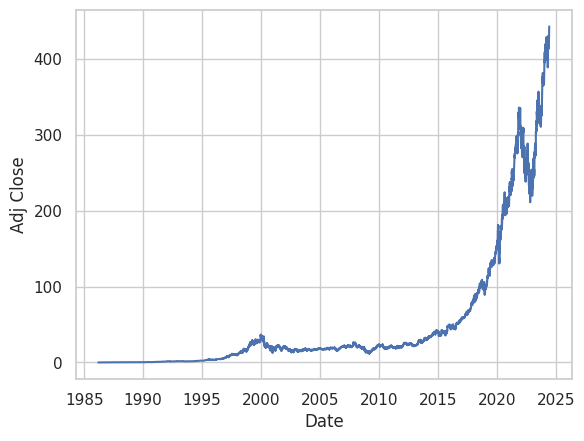

In [5]:
# Visualize Historical Prices
sns.set(style = 'whitegrid')
sns.lineplot(data = stock_prices)

In [6]:
# Check for Missing Values
stock_prices.isna().sum()

0

In [7]:
# Get Current Stock Price
S = stock_prices.tail(1).values[0]
S

442.57

**Historical Volatility**

In [8]:
# Log Returns
log_returns = np.log(stock_prices / stock_prices.shift(1)).dropna()
log_returns

Date
1986-03-14    0.000000
1986-03-17    0.000000
1986-03-18    0.000000
1986-03-19    0.000000
1986-03-20    0.000000
                ...   
2024-06-10    0.009440
2024-06-11    0.011179
2024-06-12    0.019182
2024-06-13    0.001178
2024-06-14    0.002239
Name: Adj Close, Length: 9641, dtype: float64

<Axes: xlabel='Date', ylabel='Adj Close'>

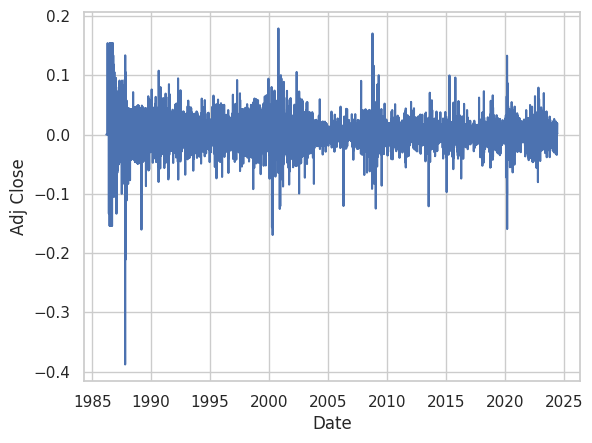

In [9]:
# Visualize the log returns
sns.lineplot(data = log_returns)

<Axes: xlabel='Adj Close', ylabel='Count'>

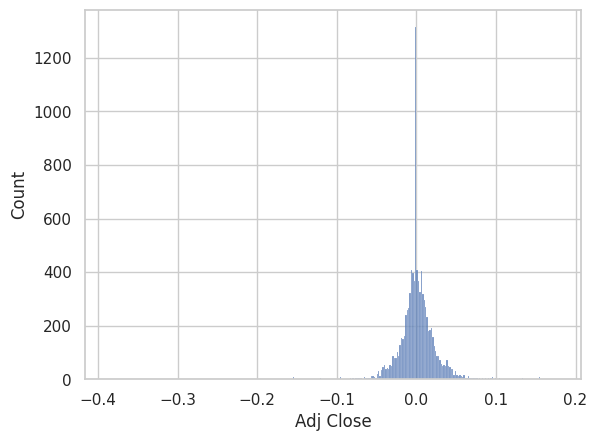

In [10]:
# Log returns histogram
sns.histplot(data = log_returns)

The stock's rate of returns follows a pattern resembling a Normal Distribution with minor fluctuations.

In [11]:
# Daily Standard Deviation of Returns
daily_std = log_returns.std()
daily_std

0.022834384036860576

In [12]:
# Annualized Standard Deviation of Returns
# 252 Trading days
annualized_std = daily_std * np.sqrt(252)
annualized_std

0.3624846090172574

Risk-free Rate

In [13]:
# The latest risk free rate of 13 Week Treasury Bill
r = yf.download('^IRX')['Adj Close'].tail(1)*0.01
r=r.values[0]
r

[*********************100%%**********************]  1 of 1 completed


0.052399997711181645

**Time to Maturity**

A breakdown of the different option expiration cycles:

Weekly Options: Weekly options have relatively short expiration periods, typically expiring on Fridays of each week. They offer more frequent opportunities for trading and can be useful for short-term trading strategies. Weekly options are introduced on a variety of underlying assets and are popular among active traders.

Monthly Options: Monthly options have longer expiration periods and typically expire on the third Friday of each month. These are often referred to as "standard" or "regular" options. They are widely traded and available for a wide range of underlying assets, including stocks, indices, and exchange-traded funds (ETFs).

Quarterly Options: Some options are structured with quarterly expiration dates, typically expiring on the last trading day of March, June, September, and December. These options are also known as "serial" options and are used less frequently than weekly and monthly options.

LEAPS (Long-Term Equity Anticipation Securities): LEAPS are long-term options with expiration dates that can extend up to several years into the future. They are often used for longer-term investment strategies or hedging purposes.

In [14]:
# Monthly Expirations: Every third Friday of the month


def get_third_fridays(year = datetime.today().year, month = datetime.today().month, num_dates = 1):
    third_fridays = []

    for _ in range(num_dates):
        dt = datetime(year, month, 1)  # Start from the first day of the month
        while dt.weekday() != 4:       # Find the first Friday
            dt = dt + timedelta(days=1)

        # Move to the third Friday
        dt = dt + timedelta(weeks=2)

        # Append third Friday's date to the list
        third_fridays.append(dt)

        # Proceed to the next month
        month = month + 1
        if month > 12:
            year = year + 1
            month = 1

    return third_fridays

third_fridays = get_third_fridays(num_dates=5)
third_fridays

[datetime.datetime(2024, 6, 21, 0, 0),
 datetime.datetime(2024, 7, 19, 0, 0),
 datetime.datetime(2024, 8, 16, 0, 0),
 datetime.datetime(2024, 9, 20, 0, 0),
 datetime.datetime(2024, 10, 18, 0, 0)]

In [15]:
# Maturity Date
third_fridays[1]

datetime.datetime(2024, 7, 19, 0, 0)

In [16]:
# Days to maturity
t = third_fridays[1] - datetime.today()
t = t.days
t

33

There are "t" days left until maturity. Subsequently, the maturity period must be converted either to an annual or trading days format.

In [17]:
# Current Stock Price
S

442.57

In [18]:
# Strike Price
K = S.round(0) + 5
K
#Assume the Strike Price at $5 higher than the current stock price.

448.0

As said before, the maturity period must be converted either to an annual or trading days format. In this case, it is converted to trading days format.

In [19]:
# Time in years
T = t / 252
T

0.13095238095238096

In [20]:
# Annualized Volatility
sigma = annualized_std
sigma

0.3624846090172574

In [21]:
# Risk-free Rate
r

0.052399997711181645

****Black-Scholes Option Pricing Formula****

In [22]:
def bs(S, K, t, r, sigma, option_type = 'c'):
    '''
    Calculate Option Price and Greeks with Black-Scholes Formula
    S = Stock Price
    K = Strike Price
    t = Time to Maturity (days)
    r = Risk-free rate
    sigma = Annualized Volatility (Standard Deviation of Returns)
    option_type = Type of Option: 'c' for call, 'p' for put
    '''

    T = t / 252   # Daily to Yearly Time to Maturity

    d1 = (np.log(S / K) + (r + (sigma ** 2) / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    try:
        if option_type == 'c':
            norm_d1 = norm.cdf(d1)
            norm_d2 = norm.cdf(d2)
            option_price = S * norm_d1 - K * np.exp(-r * T) * norm_d2
        elif option_type == 'p':
            norm_minus_d1 = norm.cdf(-d1)
            norm_minus_d2 = norm.cdf(-d2)
            option_price = K * np.exp(-r * T) * norm_minus_d2 - S * norm_minus_d1
        else:
            raise ValueError("Invalid option type. Use 'c' for call and 'p' for put.")

    # Option Greeks
        delta = norm_d1 if option_type == 'c' else -norm_minus_d1
        theta = ((-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm_d2)) / 252 if option_type == 'c' else \
                ((-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) + r * K * np.exp(-r * T) * norm_minus_d2)) / 252
        gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
        vega  = S * np.sqrt(T) * norm.pdf(d1) * sigma
        rho   = K * T * np.exp(-r * T) * norm_d2 if option_type == 'c' else \
                -K * T * np.exp(-r * T) * norm_minus_d2

    except:
        print('Invalid Input, Check the Parameters')
        return None

    return option_price.round(4), delta, theta.round(4), gamma.round(4), vega.round(4), rho.round(4)

In [23]:
S = 322.37
K = 322 + 5
t = 21
r = 0.05302
sigma = 0.3670

In [24]:
#Option Price and Option Greeks for European Call Option:
# Call Option
c_price, c_delta, c_theta, c_gamma, c_vega, c_rho = bs(S, K, t, r, sigma, option_type = 'c')
print(f'Option Price: {c_price}')
print(f'Delta: {c_delta}')
print(f'Theta: {c_theta}')
print(f'Gamma: {c_gamma}')
print(f'Vega: {c_vega}')
print(f'Rho: {c_rho}')

Option Price: 12.1509
Delta: 0.48407632256035754
Theta: -0.3544
Gamma: 0.0117
Vega: 13.6143
Rho: 11.9917


In [25]:
#Option Price and Option Greeks for European Put Option:
# Put Option
p_price, p_delta, p_theta, p_gamma, p_vega, p_rho = bs(S, K, t, r, sigma, option_type = 'p')
print(f'Option Price: {p_price}')
print(f'Delta: {p_delta}')
print(f'Theta: {p_theta}')
print(f'Gamma: {p_gamma}')
print(f'Vega: {p_vega}')
print(f'Rho: {p_rho}')

Option Price: 15.3392
Delta: -0.5159236774396424
Theta: -0.2859
Gamma: 0.0117
Vega: 13.6143
Rho: -15.1381


Until this point, the Black-Scholes Option Pricing Model has been applied using real-world data. It would be advantageous to visualize relevant graphs, such as profit/loss graphs, variations of Greeks, and even 3D representations of option Greeks, to enhance understanding

****The Option DataFrame****

Call Option P/L

In [28]:
#Generate a profit/loss profile based on the corresponding stock prices
call_graph = pd.DataFrame({'stock_price': np.arange(S-70,S+70,0.01)})

call_graph['pnl_long'] = np.maximum(0, call_graph.stock_price - K) - c_price
call_graph['pnl_short'] = -call_graph['pnl_long']

call_graph.head()

,stock_price,pnl_long,pnl_short
0,252.37,-12.1509,12.1509
1,252.38,-12.1509,12.1509
2,252.39,-12.1509,12.1509
3,252.40,-12.1509,12.1509
4,252.41,-12.1509,12.1509


Call Option Price and Greeks

In [29]:
#Generate a option price and greeks based on the corresponding stock prices.
list_column = ['option_price', 'delta', 'theta', 'gamma', 'vega', 'rho']
for index, value in enumerate(list_column):
    call_graph[f'call_{value}'] = bs(S = call_graph.stock_price, K = K, t = t, r = r, sigma = sigma, option_type = 'c')[index]

call_graph.head()

,stock_price,pnl_long,pnl_short,call_option_price,call_delta,call_theta,call_gamma,call_vega,call_rho
0,252.37,-12.1509,12.1509,0.0816,0.009371,-0.0165,0.0009,0.6733,0.1903
1,252.38,-12.1509,12.1509,0.0817,0.009381,-0.0165,0.0009,0.6739,0.1905
2,252.39,-12.1509,12.1509,0.0818,0.009390,-0.0165,0.0009,0.6745,0.1907
3,252.40,-12.1509,12.1509,0.0819,0.009399,-0.0166,0.0009,0.6751,0.1909
4,252.41,-12.1509,12.1509,0.0820,0.009409,-0.0166,0.0009,0.6758,0.1911


In [30]:
call_graph.to_csv('call_graph.csv', index=False)

Put Option P/L

In [31]:
put_graph = pd.DataFrame({'stock_price': call_graph.stock_price})

put_graph['pnl_long'] = np.maximum(0, K - put_graph.stock_price) - p_price
put_graph['pnl_short'] = -put_graph['pnl_long']

put_graph.head()

,stock_price,pnl_long,pnl_short
0,252.37,59.2908,-59.2908
1,252.38,59.2808,-59.2808
2,252.39,59.2708,-59.2708
3,252.40,59.2608,-59.2608
4,252.41,59.2508,-59.2508


In [32]:
for index, value in enumerate(list_column):
    put_graph[f'put_{value}'] = bs(S = put_graph.stock_price, K = K, t = t, r = r, sigma = sigma, option_type = 'p')[index]

put_graph.head()

,stock_price,pnl_long,pnl_short,put_option_price,put_delta,put_theta,put_gamma,put_vega,put_rho
0,252.37,59.2908,-59.2908,73.2700,-0.990629,0.0520,0.0009,0.6733,-26.9396
1,252.38,59.2808,-59.2808,73.2601,-0.990619,0.0520,0.0009,0.6739,-26.9394
2,252.39,59.2708,-59.2708,73.2502,-0.990610,0.0520,0.0009,0.6745,-26.9392
3,252.40,59.2608,-59.2608,73.2403,-0.990601,0.0519,0.0009,0.6751,-26.9390
4,252.41,59.2508,-59.2508,73.2304,-0.990591,0.0519,0.0009,0.6758,-26.9388


In [33]:
put_graph.to_csv('put_graph.csv', index=False)

**Profit and Loss Graphs**

Construct an interactive profit/loss graph to enhance comprehension.

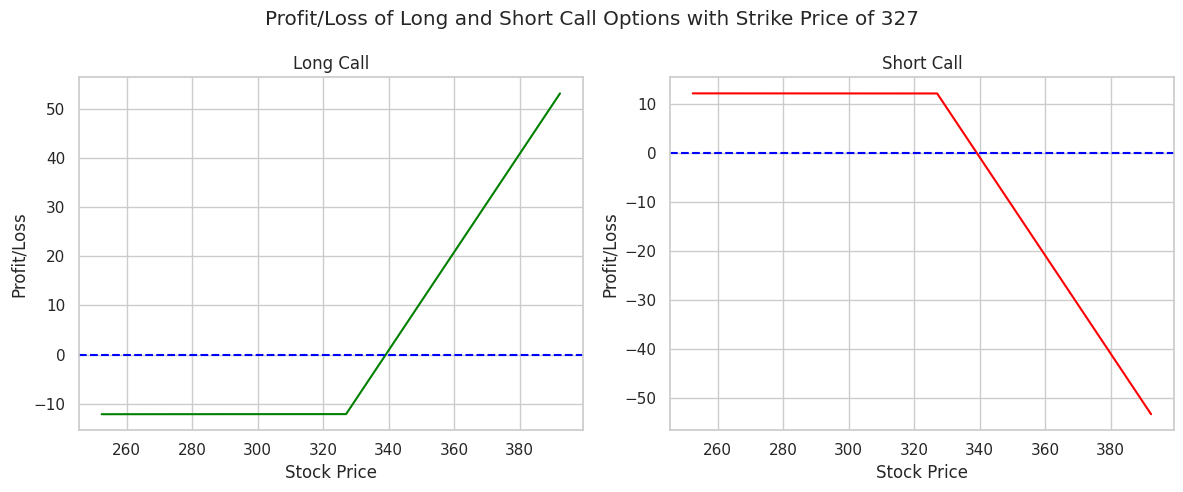

In [34]:
plt.figure(figsize = (12, 5))

# Long Call
plt.subplot(1,2,1)
pnl_call = sns.lineplot(data = call_graph, x = 'stock_price', y = 'pnl_long', color = 'green')
pnl_call.axhline(0, color = 'blue', linestyle = '--')

# Title
plt.title('Long Call')
plt.xlabel('Stock Price')
plt.ylabel('Profit/Loss')

# Short Call
plt.subplot(1,2,2)
pnl_call = sns.lineplot(data = call_graph, x = 'stock_price', y = 'pnl_short', color = 'red')
pnl_call.axhline(0, color = 'blue', linestyle = '--')

# Title
plt.title('Short Call')
plt.xlabel('Stock Price')
plt.ylabel('Profit/Loss')

plt.suptitle(f'Profit/Loss of Long and Short Call Options with Strike Price of {K}')

plt.tight_layout()
plt.show()

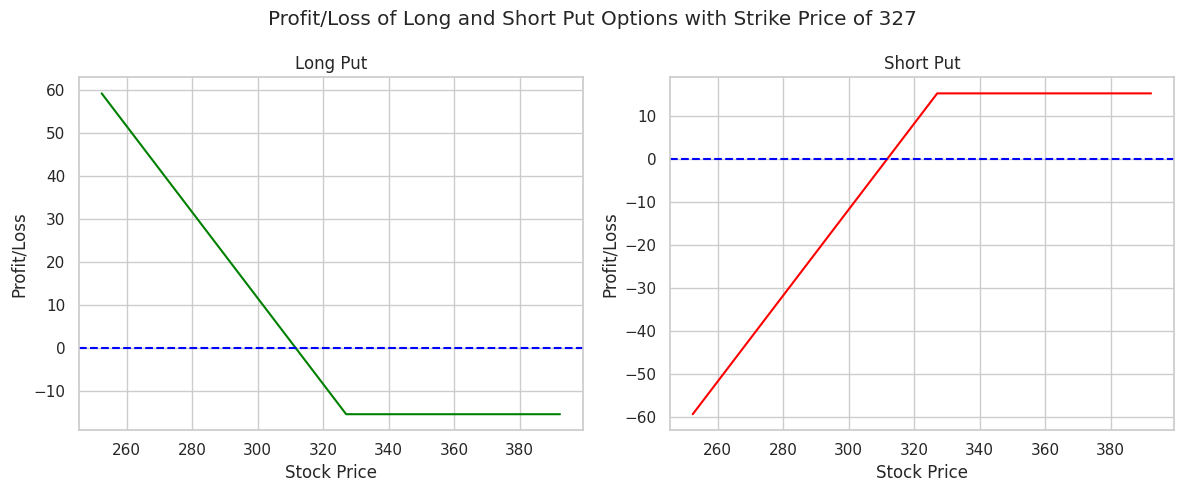

In [35]:
plt.figure(figsize = (12, 5))

# Long Put
plt.subplot(1,2,1)
pnl_put = sns.lineplot(data = put_graph, x = 'stock_price', y = 'pnl_long', color = 'green')
pnl_put.axhline(0, color = 'blue', linestyle = '--')

# Title
plt.title('Long Put')
plt.xlabel('Stock Price')
plt.ylabel('Profit/Loss')

# Short Put
plt.subplot(1,2,2)
pnl_put = sns.lineplot(data = put_graph, x = 'stock_price', y = 'pnl_short', color = 'red')
pnl_put.axhline(0, color = 'blue', linestyle = '--')

# Title
plt.title('Short Put')
plt.xlabel('Stock Price')
plt.ylabel('Profit/Loss')

plt.suptitle(f'Profit/Loss of Long and Short Put Options with Strike Price of {K}')
plt.tight_layout()
plt.show()

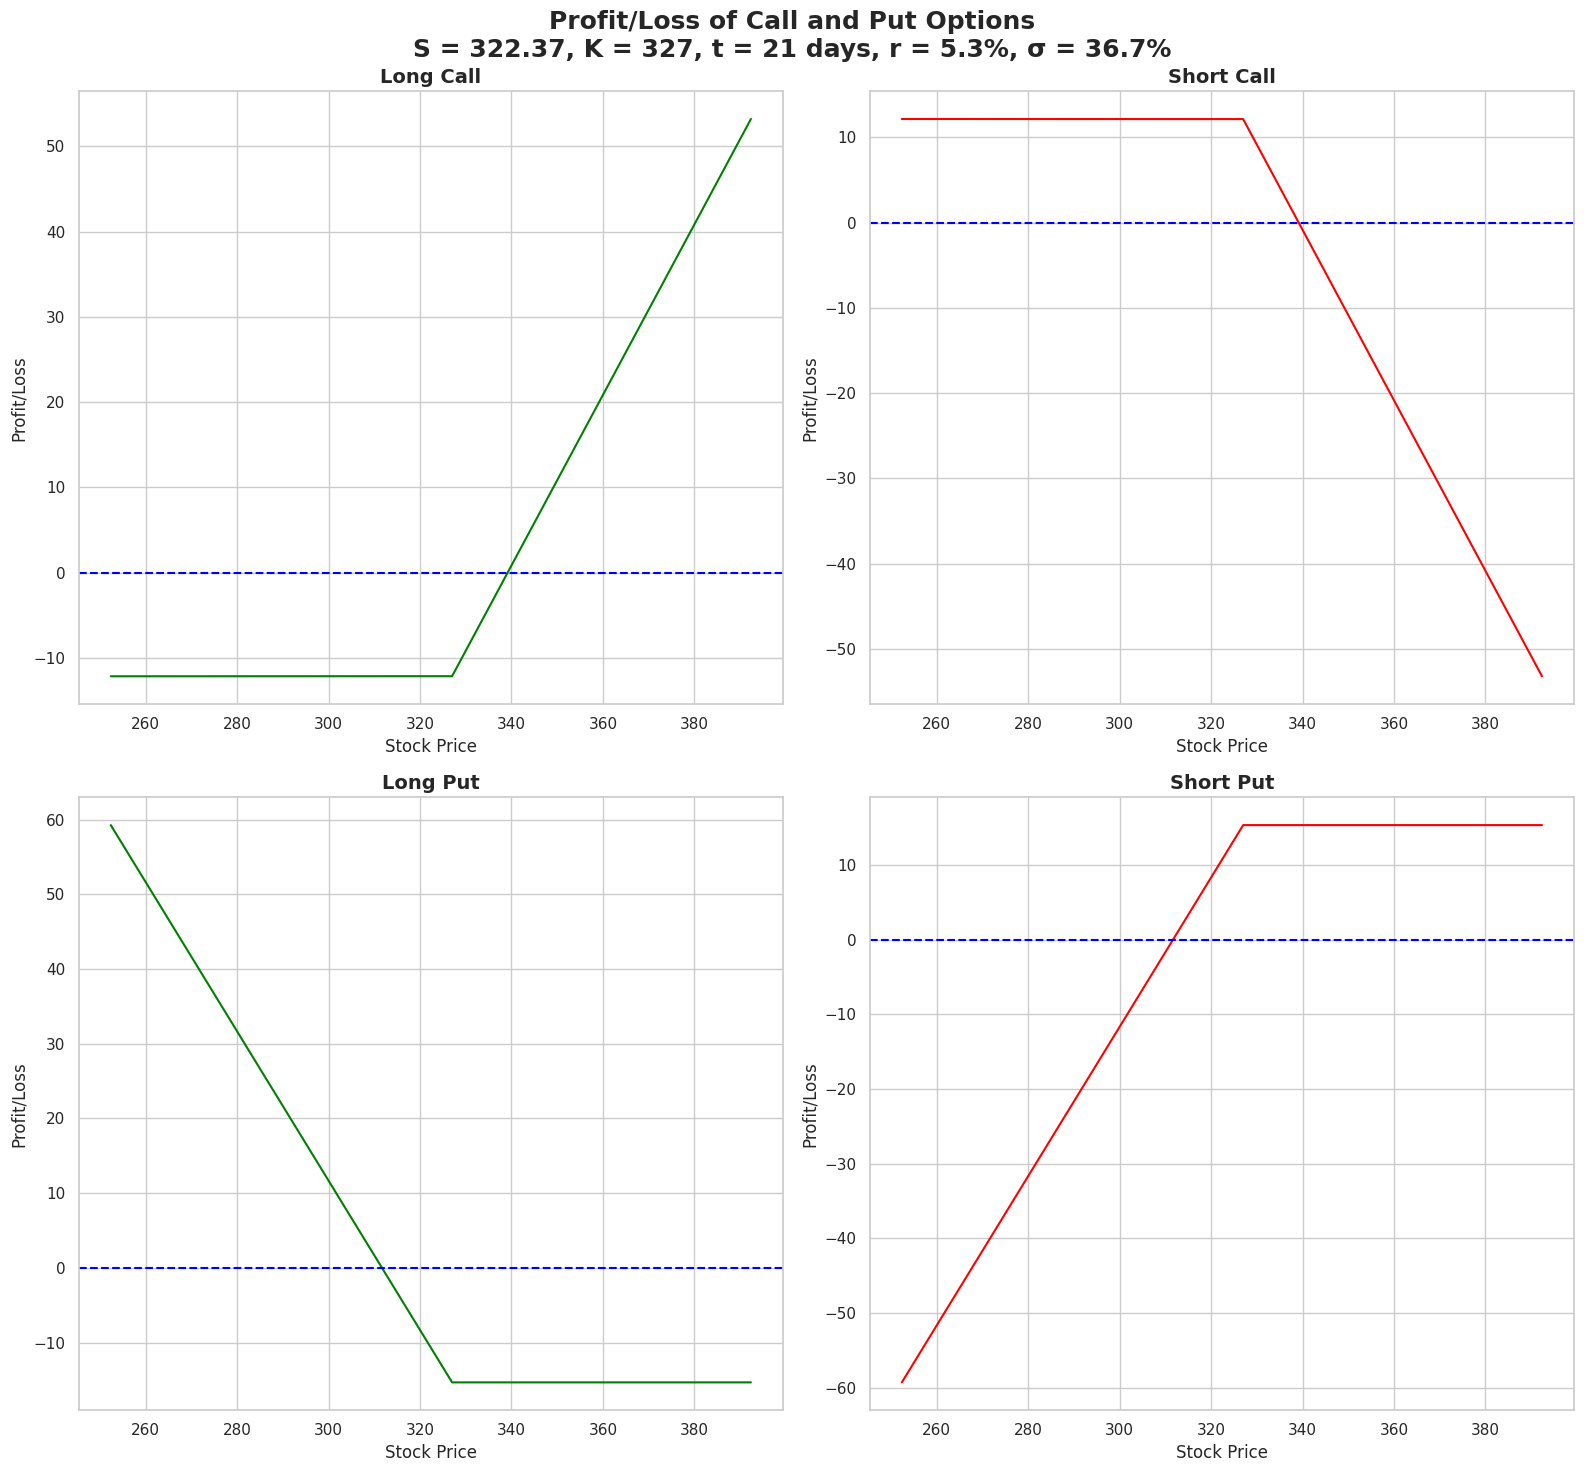

In [36]:
# Create a figure with a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 15))

# Long Put subplot
pnl_long_long = sns.lineplot(data=call_graph, x='stock_price', y='pnl_long', color='green', ax=axs[0, 0])
pnl_long_long.axhline(0, color='blue', linestyle='--')
axs[0, 0].set_title('Long Call', size = 14, fontweight = 'bold')
axs[0, 0].set_xlabel('Stock Price')
axs[0, 0].set_ylabel('Profit/Loss')

# Short long subplot
pnl_short_long = sns.lineplot(data=call_graph, x='stock_price', y='pnl_short', color='red', ax=axs[0, 1])
pnl_short_long.axhline(0, color='blue', linestyle='--')
axs[0, 1].set_title('Short Call', size = 14, fontweight = 'bold')
axs[0, 1].set_xlabel('Stock Price')
axs[0, 1].set_ylabel('Profit/Loss')

# Additional Long Put subplot (row 2, column 1)
pnl_long_put_2 = sns.lineplot(data=put_graph, x='stock_price', y='pnl_long', color='green', ax=axs[1, 0])
pnl_long_put_2.axhline(0, color='blue', linestyle='--')
axs[1, 0].set_title('Long Put', size = 14, fontweight = 'bold')
axs[1, 0].set_xlabel('Stock Price')
axs[1, 0].set_ylabel('Profit/Loss')

# Additional Short Put subplot (row 2, column 2)
pnl_short_put_2 = sns.lineplot(data=put_graph, x='stock_price', y='pnl_short', color='red', ax=axs[1, 1])
pnl_short_put_2.axhline(0, color='blue', linestyle='--')
axs[1, 1].set_title('Short Put', size = 14, fontweight = 'bold')
axs[1, 1].set_xlabel('Stock Price')
axs[1, 1].set_ylabel('Profit/Loss')

# Add the super title with two lines
suptitle_line1 = 'Profit/Loss of Call and Put Options'
suptitle_line2 = f'S = {S}, K = {K}, t = {t} days, r = {np.round(r * 100, 2)}%, σ = {np.round(sigma * 100, 2)}%'
plt.suptitle(f'{suptitle_line1}\n{suptitle_line2}', size=18, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()


Stock Price and Option Price Relationship

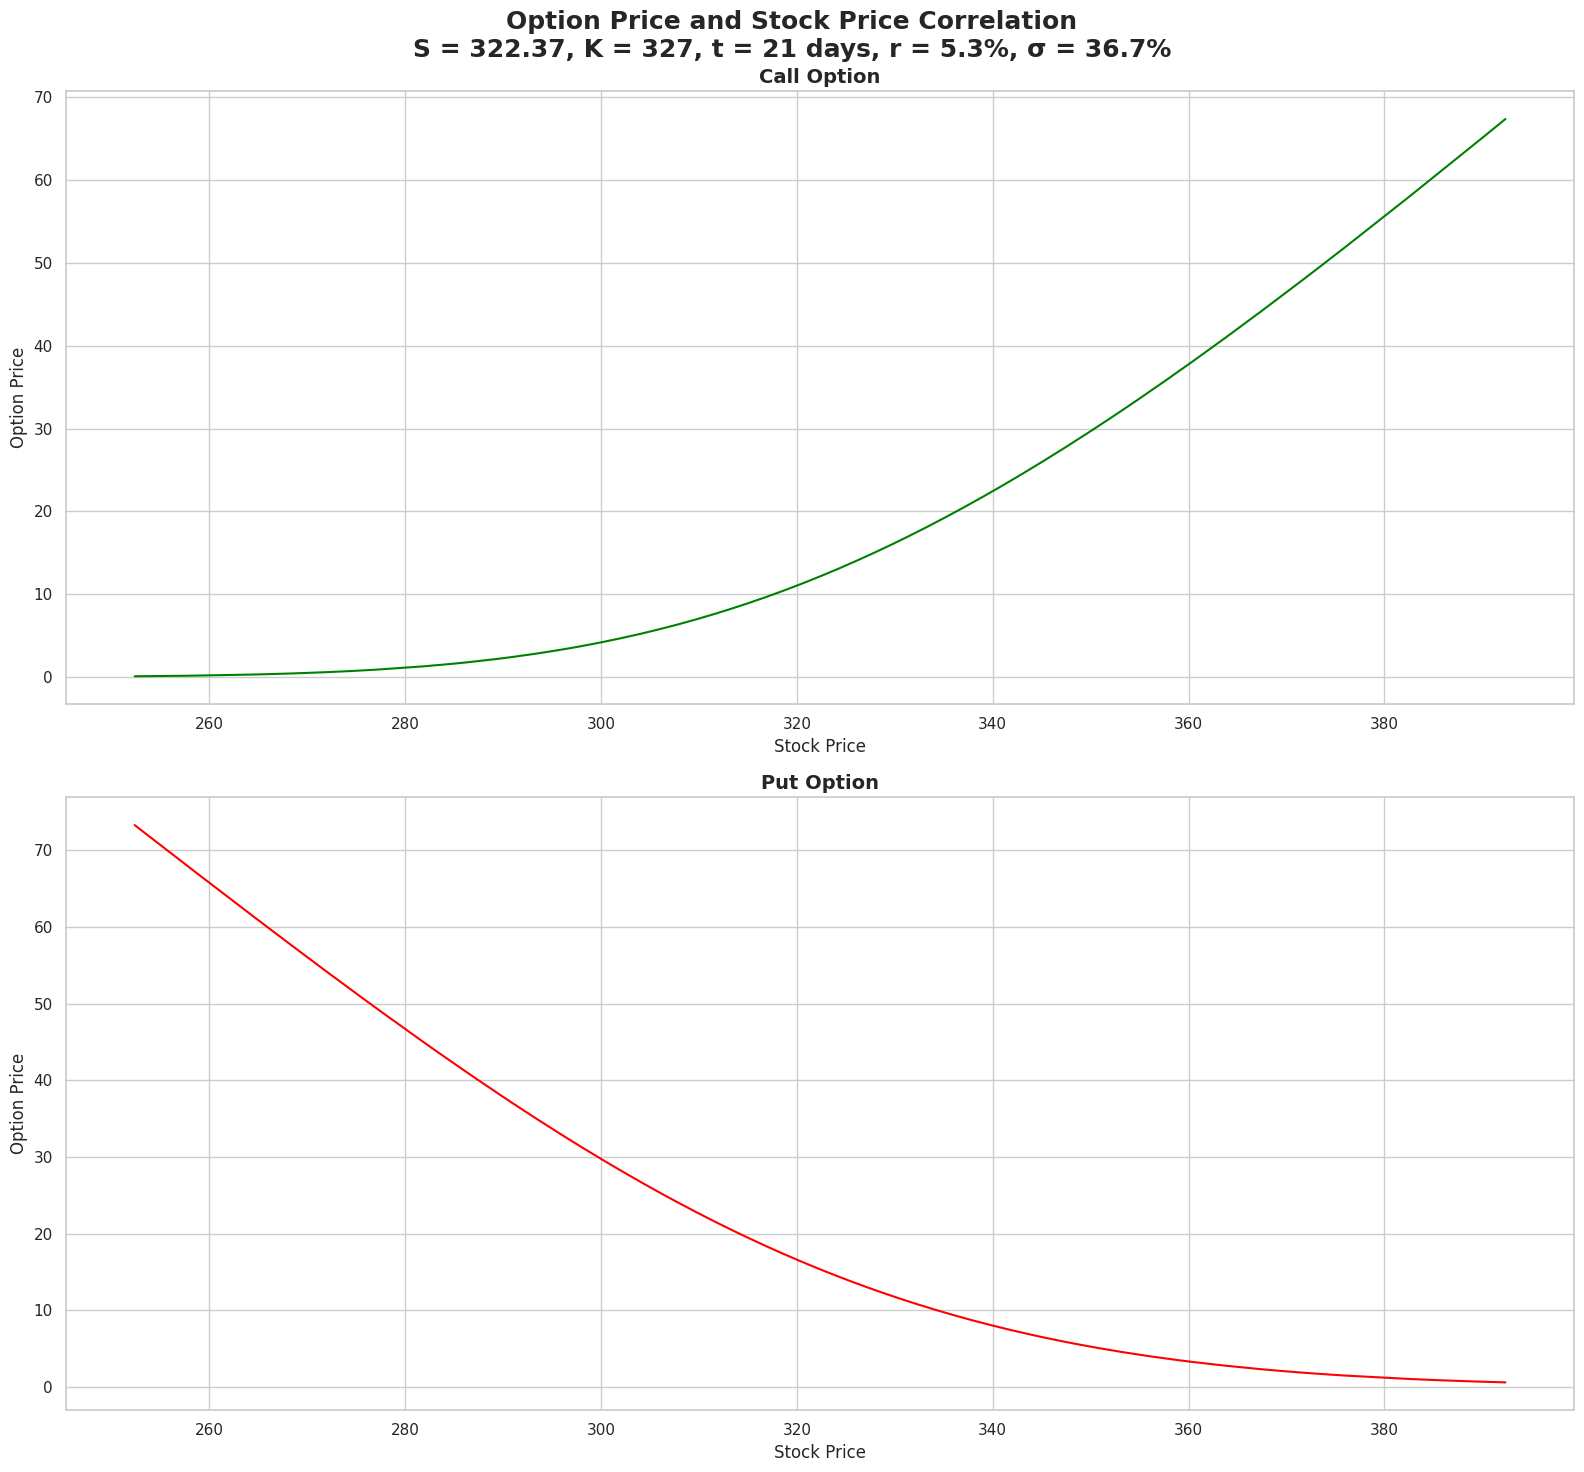

In [37]:
plt.figure(figsize = (16, 15))

# Call Option
plt.subplot(2,1,1)
pnl_call = sns.lineplot(data = call_graph, x = 'stock_price', y = 'call_option_price', color = 'green')

# Title
plt.title('Call Option', size = 14, fontweight = 'bold')
plt.xlabel('Stock Price')
plt.ylabel('Option Price')

# Put Option
plt.subplot(2,1,2)
pnl_call = sns.lineplot(data = put_graph, x = 'stock_price', y = 'put_option_price', color = 'red')

# Title
plt.title('Put Option', size = 14, fontweight = 'bold')
plt.xlabel('Stock Price')
plt.ylabel('Option Price')

# Add the super title with two lines
suptitle_line1 = 'Option Price and Stock Price Correlation'
suptitle_line2 = f'S = {S}, K = {K}, t = {t} days, r = {np.round(r * 100, 2)}%, σ = {np.round(sigma * 100, 2)}%'
plt.suptitle(f'{suptitle_line1}\n{suptitle_line2}', size=18, fontweight='bold')
plt.tight_layout()
plt.show()

**Option Greeks**

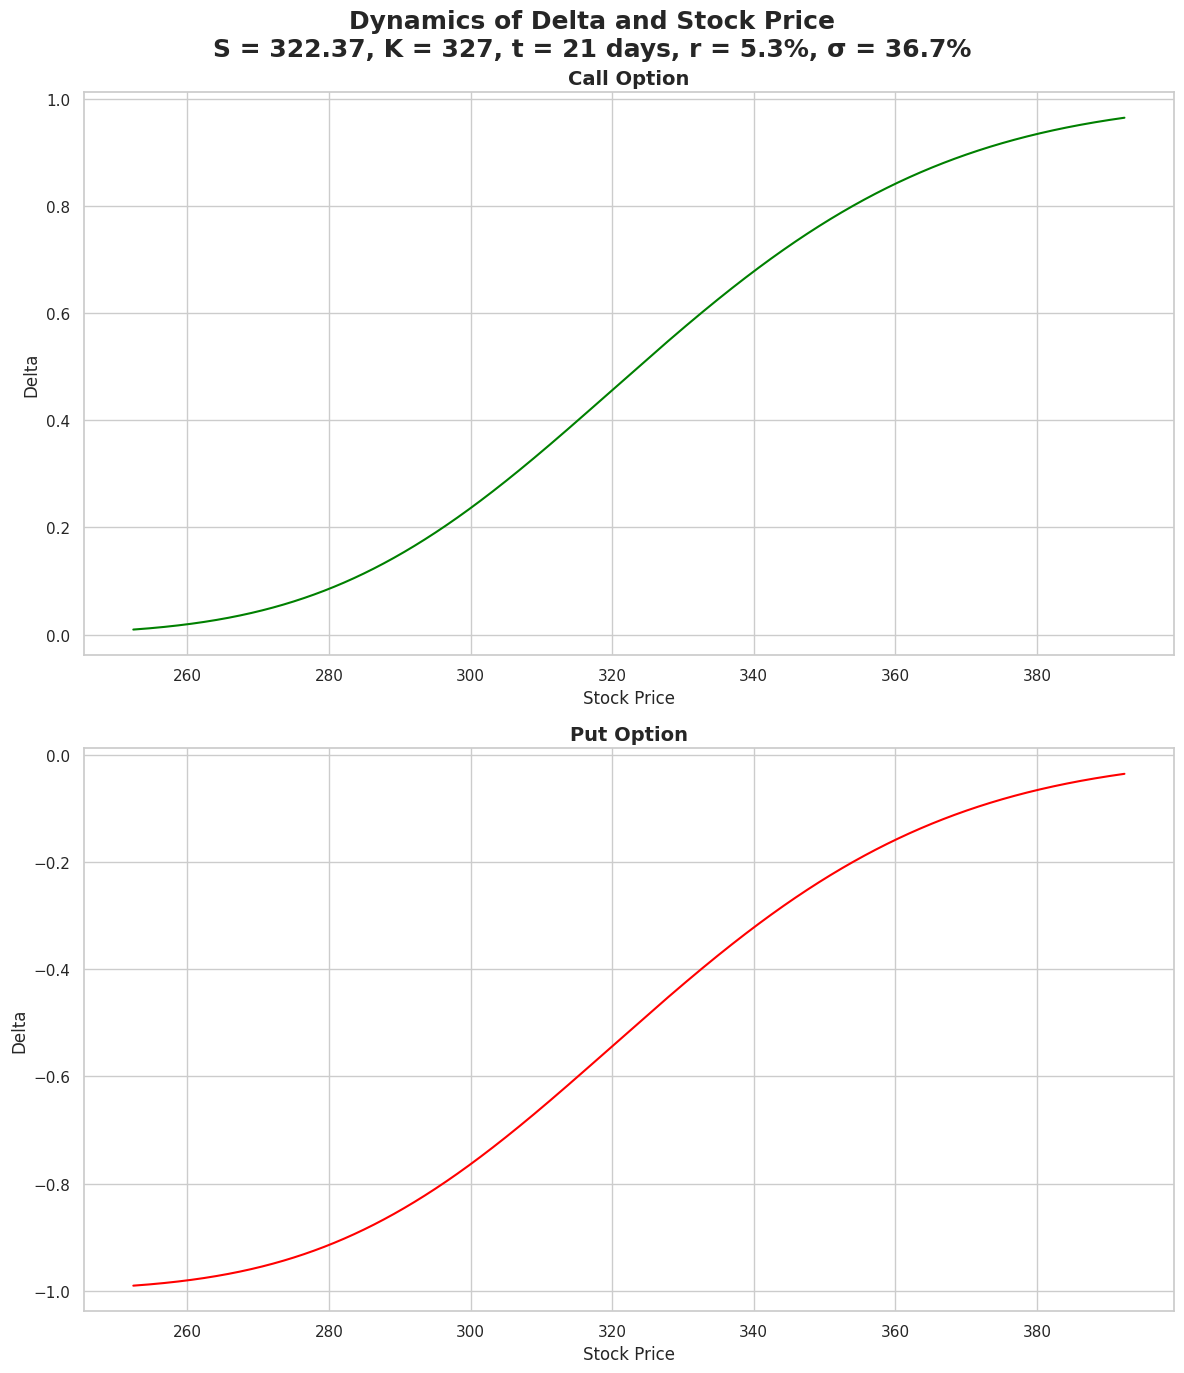

In [38]:
plt.figure(figsize = (12, 14))

# Call Option
plt.subplot(2,1,1)
pnl_call = sns.lineplot(data = call_graph, x = 'stock_price', y = 'call_delta', color = 'green')

# Title
plt.title('Call Option', size = 14, fontweight = 'bold')
plt.xlabel('Stock Price')
plt.ylabel('Delta')

# Put Option
plt.subplot(2,1,2)
pnl_call = sns.lineplot(data = put_graph, x = 'stock_price', y = 'put_delta', color = 'red')

# Title
plt.title('Put Option', size = 14, fontweight = 'bold')
plt.xlabel('Stock Price')
plt.ylabel('Delta')

# Add the super title with two lines
suptitle_line1 = 'Dynamics of Delta and Stock Price'
suptitle_line2 = f'S = {S}, K = {K}, t = {t} days, r = {np.round(r * 100, 2)}%, σ = {np.round(sigma * 100, 2)}%'
plt.suptitle(f'{suptitle_line1}\n{suptitle_line2}', size=18, fontweight='bold')
plt.tight_layout()
plt.show()

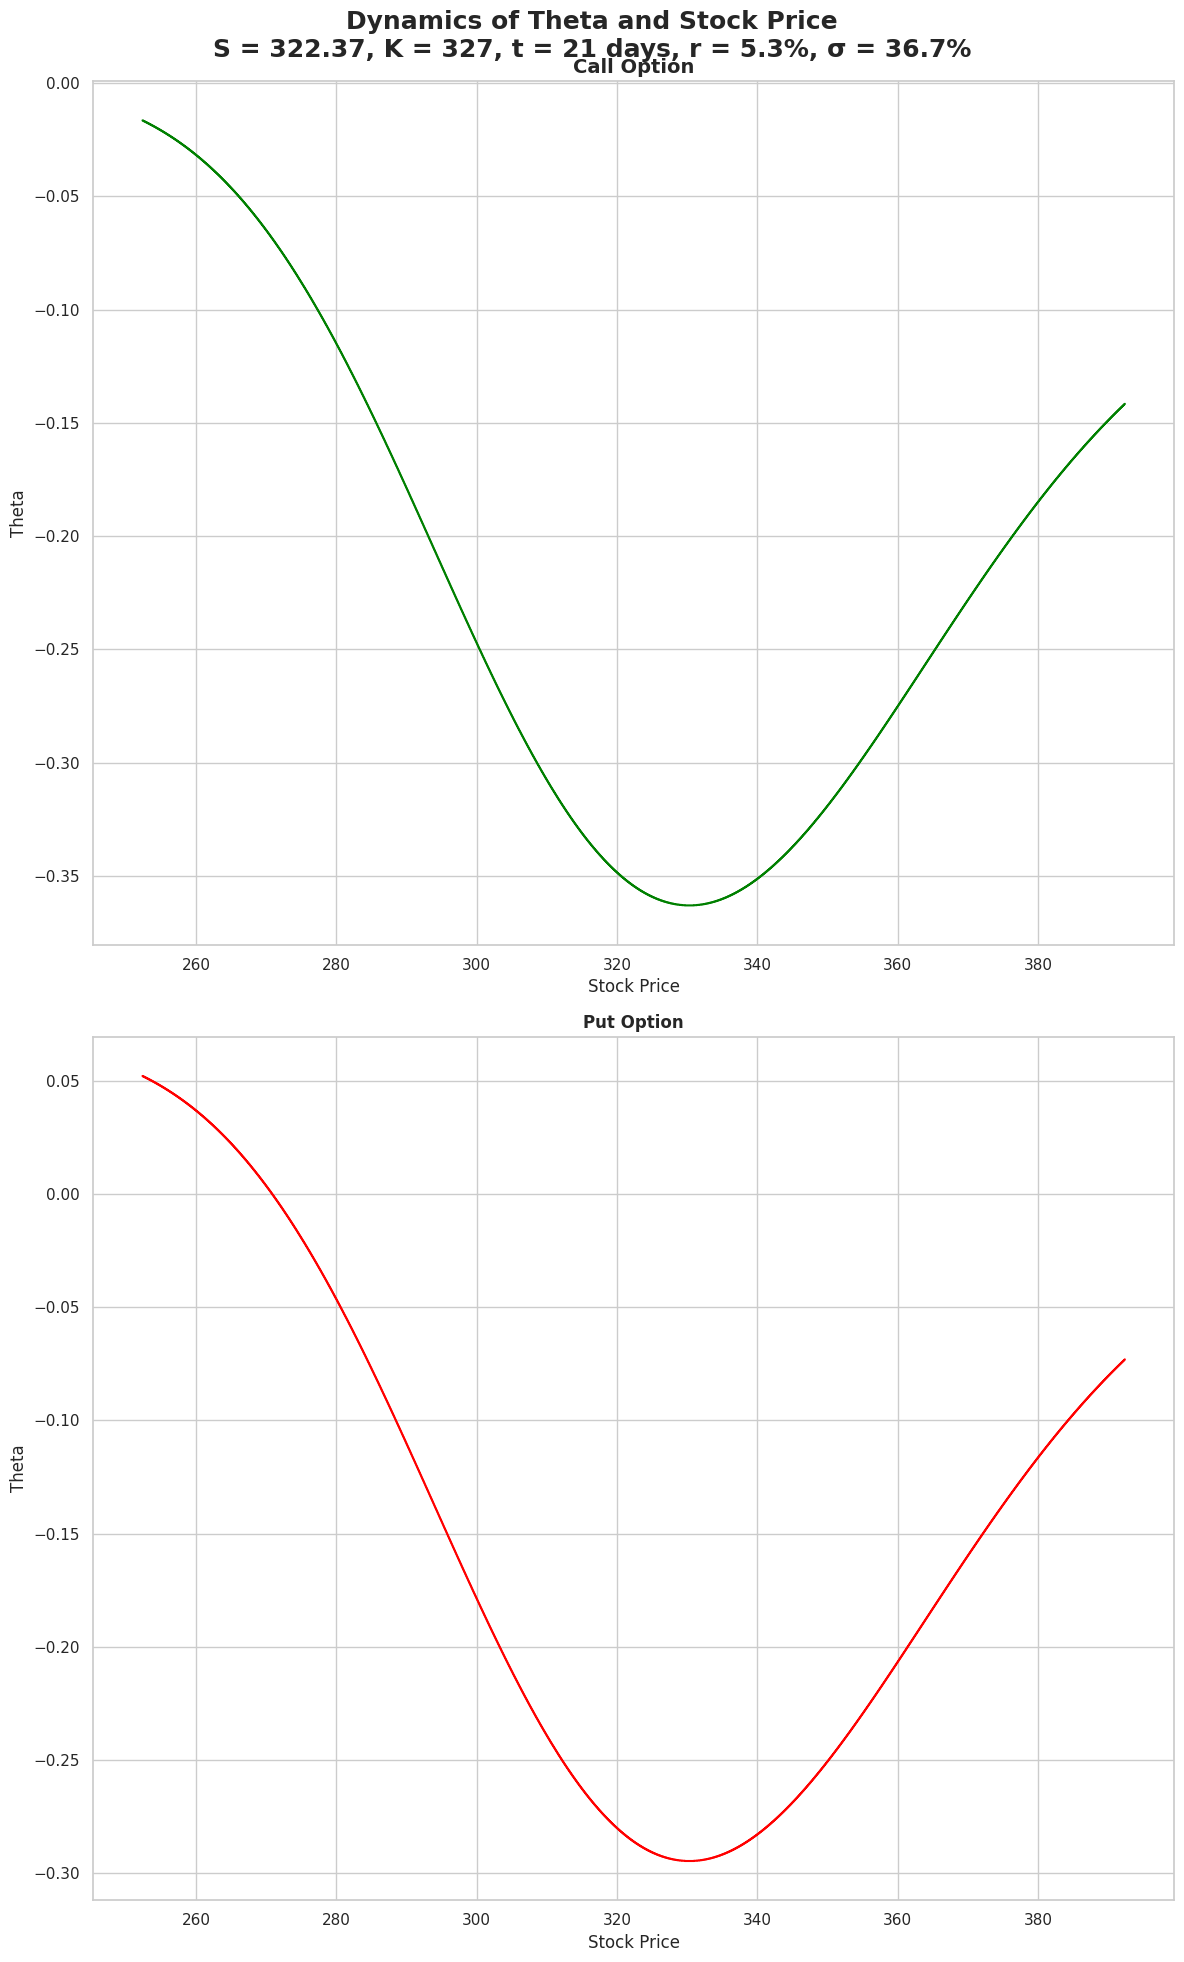

In [39]:
plt.figure(figsize = (12, 20))

# Call Option
plt.subplot(2,1,1)
pnl_call = sns.lineplot(data = call_graph, x = 'stock_price', y = 'call_theta', color = 'green')

# Title
plt.title('Call Option', size = 14, fontweight = 'bold')
plt.xlabel('Stock Price')
plt.ylabel('Theta')

# Put Option
plt.subplot(2,1,2)
pnl_call = sns.lineplot(data = put_graph, x = 'stock_price', y = 'put_theta', color = 'red')

# Title
plt.title('Put Option', size = 12, fontweight = 'bold')
plt.xlabel('Stock Price')
plt.ylabel('Theta')

# Add the super title with two lines
suptitle_line1 = 'Dynamics of Theta and Stock Price'
suptitle_line2 = f'S = {S}, K = {K}, t = {t} days, r = {np.round(r * 100, 2)}%, σ = {np.round(sigma * 100, 2)}%'
plt.suptitle(f'{suptitle_line1}\n{suptitle_line2}', size=18, fontweight='bold')
plt.tight_layout()
plt.show()

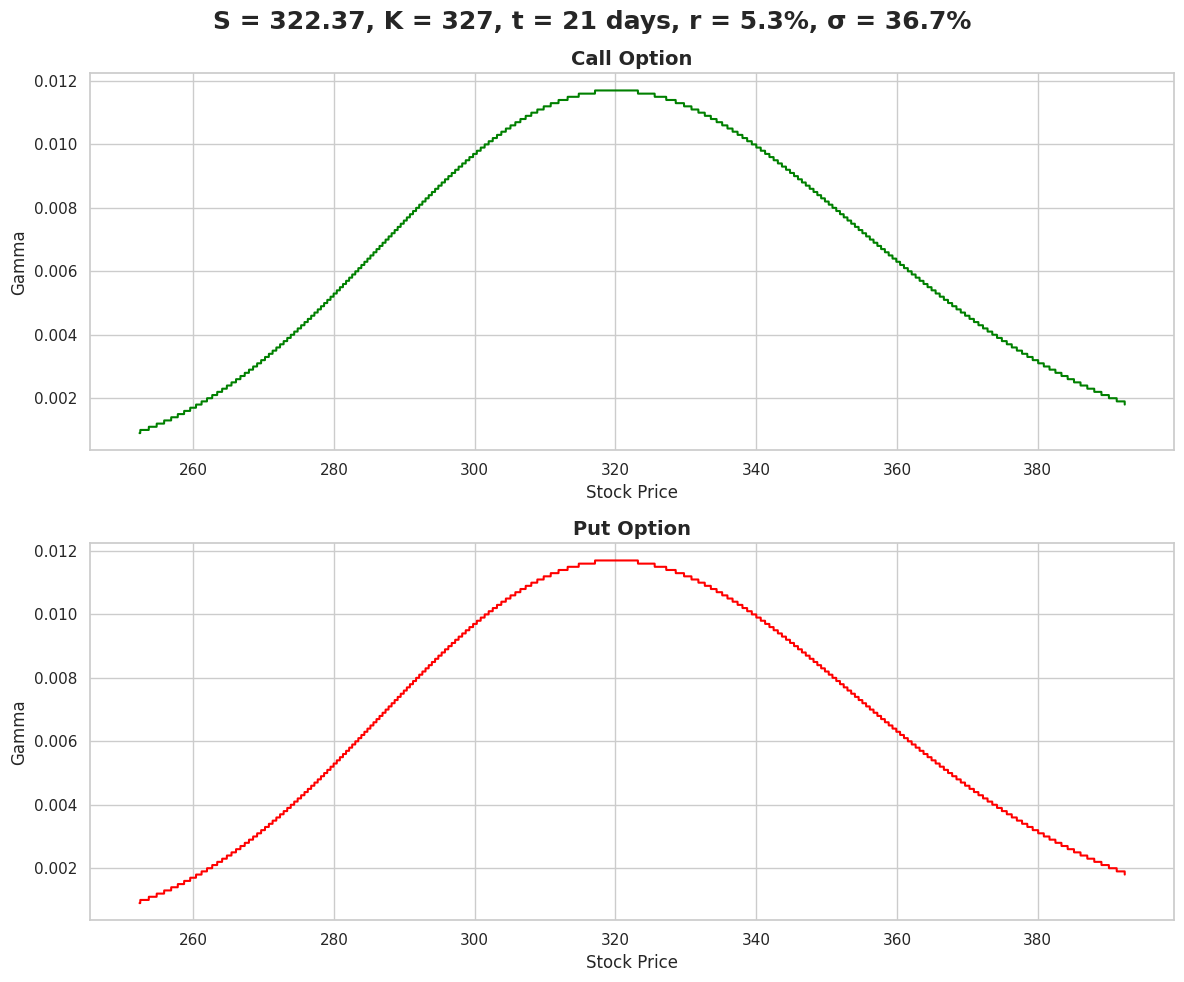

In [40]:
plt.figure(figsize = (12, 10))

# Call Option
plt.subplot(2,1,1)
pnl_call = sns.lineplot(data = call_graph, x = 'stock_price', y = 'call_gamma', color = 'green')

# Title
plt.title('Call Option', size = 14, fontweight = 'bold')
plt.xlabel('Stock Price')
plt.ylabel('Gamma')

# Put Option
plt.subplot(2,1,2)
pnl_call = sns.lineplot(data = put_graph, x = 'stock_price', y = 'put_gamma', color = 'red')

# Title
plt.title('Put Option', size = 14, fontweight = 'bold')
plt.xlabel('Stock Price')
plt.ylabel('Gamma')

plt.suptitle(f'S = {S}, K = {K}, t = {t} days, r = {np.round(r * 100,2)}%, σ = {sigma * 100}%', fontweight = 'bold', size = 18)
plt.tight_layout()
plt.show()

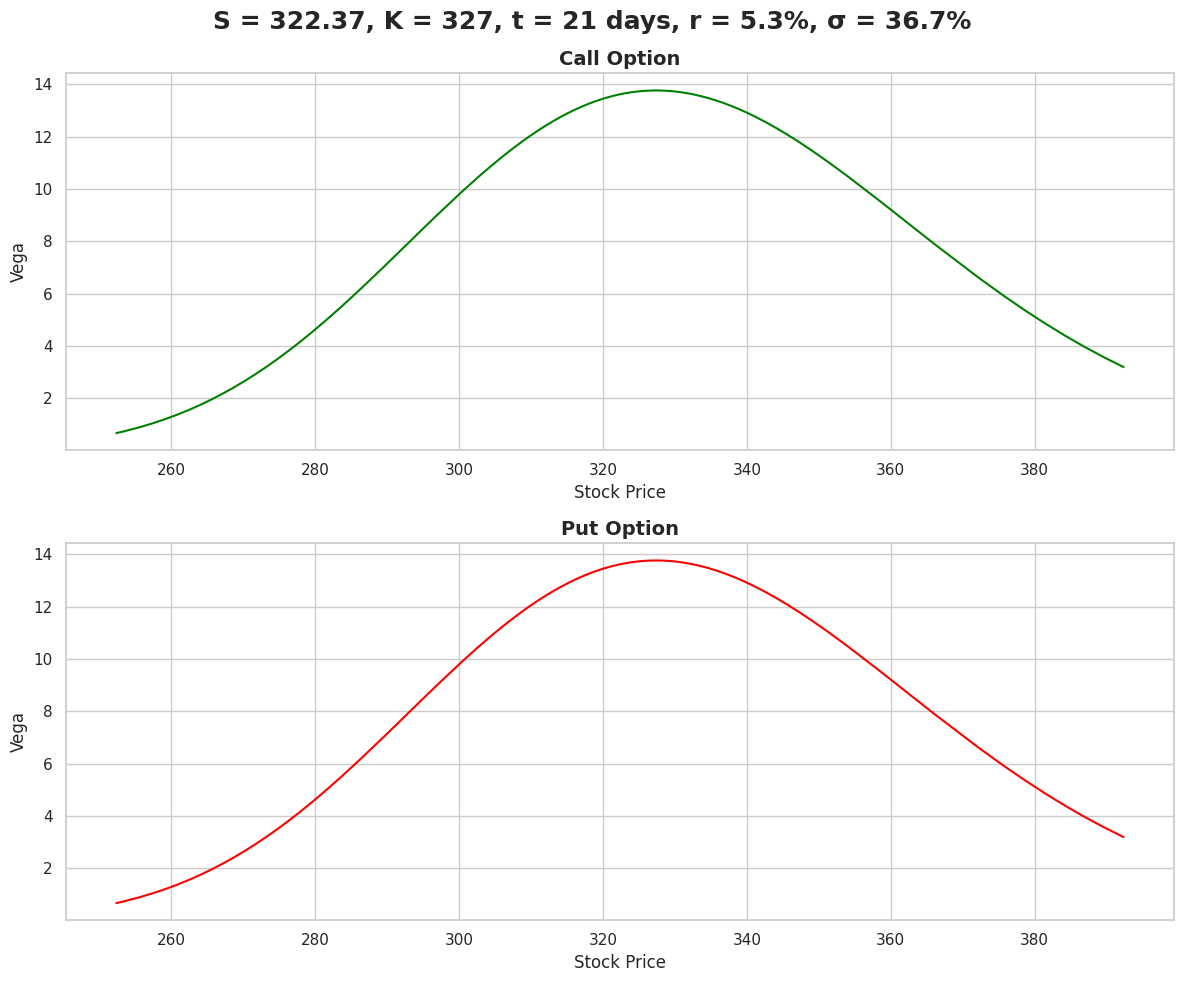

In [41]:
plt.figure(figsize = (12, 10))

# Call Option
plt.subplot(2,1,1)
pnl_call = sns.lineplot(data = call_graph, x = 'stock_price', y = 'call_vega', color = 'green')

# Title
plt.title('Call Option', size = 14, fontweight = 'bold')
plt.xlabel('Stock Price')
plt.ylabel('Vega')

# Put Option
plt.subplot(2,1,2)
pnl_call = sns.lineplot(data = put_graph, x = 'stock_price', y = 'put_vega', color = 'red')

# Title
plt.title('Put Option', size = 14, fontweight = 'bold')
plt.xlabel('Stock Price')
plt.ylabel('Vega')

plt.suptitle(f'S = {S}, K = {K}, t = {t} days, r = {np.round(r * 100,2)}%, σ = {sigma * 100}%', fontweight = 'bold', size = 18)
plt.tight_layout()
plt.show()

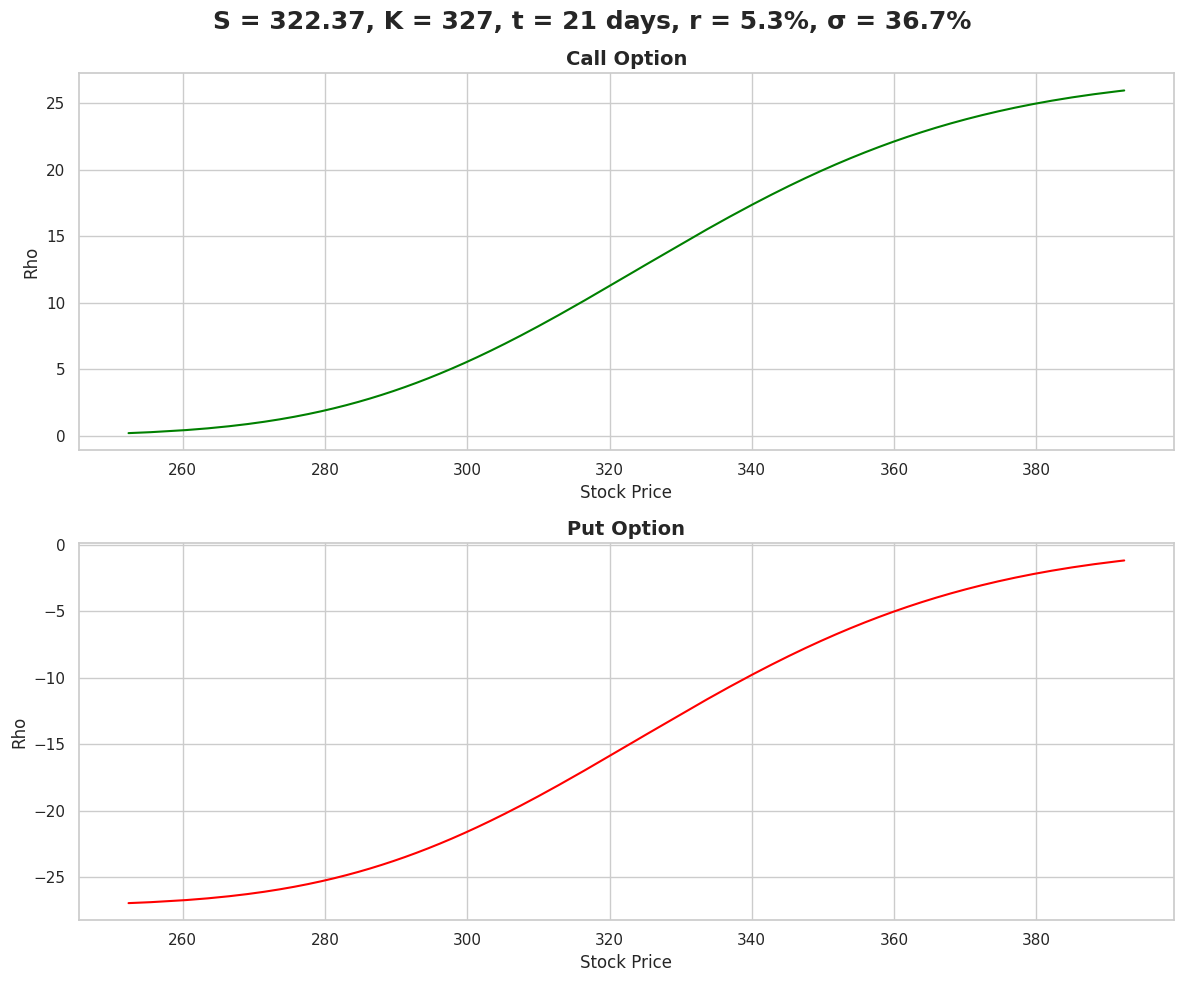

In [42]:
plt.figure(figsize = (12, 10))

# Call Option
plt.subplot(2,1,1)
pnl_call = sns.lineplot(data = call_graph, x = 'stock_price', y = 'call_rho', color = 'green')

# Title
plt.title('Call Option', size = 14, fontweight = 'bold')
plt.xlabel('Stock Price')
plt.ylabel('Rho')

# Put Option
plt.subplot(2,1,2)
pnl_call = sns.lineplot(data = put_graph, x = 'stock_price', y = 'put_rho', color = 'red')

# Title
plt.title('Put Option', size = 14, fontweight = 'bold')
plt.xlabel('Stock Price')
plt.ylabel('Rho')

plt.suptitle(f'S = {S}, K = {K}, t = {t} days, r = {np.round(r * 100,2)}%, σ = {sigma * 100}%', fontweight = 'bold', size = 18)
plt.tight_layout()
plt.show()

**3D Graphs**

***Option Greeks as a function of Stock Price and Time to Maturity.***

In [43]:
stock_price = np.arange(S-120,S+120,0.1)
ttm = np.arange(t,0, -1)

In [44]:
list_greeks = ['delta', 'theta', 'gamma', 'vega', 'rho']

In [45]:
x = stock_price
x

array([202.37, 202.47, 202.57, ..., 442.07, 442.17, 442.27])

In [46]:
y = ttm
y

array([21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,
        4,  3,  2,  1])

In [47]:
X, Y = np.meshgrid(x,y)

In [48]:
X

array([[202.37, 202.47, 202.57, ..., 442.07, 442.17, 442.27],
       [202.37, 202.47, 202.57, ..., 442.07, 442.17, 442.27],
       [202.37, 202.47, 202.57, ..., 442.07, 442.17, 442.27],
       ...,
       [202.37, 202.47, 202.57, ..., 442.07, 442.17, 442.27],
       [202.37, 202.47, 202.57, ..., 442.07, 442.17, 442.27],
       [202.37, 202.47, 202.57, ..., 442.07, 442.17, 442.27]])

In [49]:
Y

array([[21, 21, 21, ..., 21, 21, 21],
       [20, 20, 20, ..., 20, 20, 20],
       [19, 19, 19, ..., 19, 19, 19],
       ...,
       [ 3,  3,  3, ...,  3,  3,  3],
       [ 2,  2,  2, ...,  2,  2,  2],
       [ 1,  1,  1, ...,  1,  1,  1]])

In [50]:
def z_function(x, y):
    return bs(S = x, K = K, t = y, r = r, sigma = sigma, option_type = 'c')

In [51]:
Z = z_function(X, Y)
Z

(array([[  0.    ,   0.    ,   0.    , ..., 116.5343, 116.6341, 116.734 ],
        [  0.    ,   0.    ,   0.    , ..., 116.4605, 116.5604, 116.6603],
        [  0.    ,   0.    ,   0.    , ..., 116.3876, 116.4875, 116.5874],
        ...,
        [  0.    ,   0.    ,   0.    , ..., 115.2763, 115.3763, 115.4763],
        [  0.    ,   0.    ,   0.    , ..., 115.2076, 115.3076, 115.4076],
        [  0.    ,   0.    ,   0.    , ..., 115.1388, 115.2388, 115.3388]]),
 array([[4.60937629e-06, 4.71018056e-06, 4.81303752e-06, ...,
         9.98362123e-01, 9.98373375e-01, 9.98384554e-01],
        [2.69678508e-06, 2.75867954e-06, 2.82190101e-06, ...,
         9.98687730e-01, 9.98697147e-01, 9.98706500e-01],
        [1.49301746e-06, 1.52907082e-06, 1.56594011e-06, ...,
         9.98971992e-01, 9.98979716e-01, 9.98987386e-01],
        ...,
        [3.32932719e-33, 3.86174090e-33, 4.47829156e-33, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
        [6.96377067e-49, 8.69682152e-49, 1

In [52]:
for i in list_greeks:
    print(i)

delta
theta
gamma
vega
rho


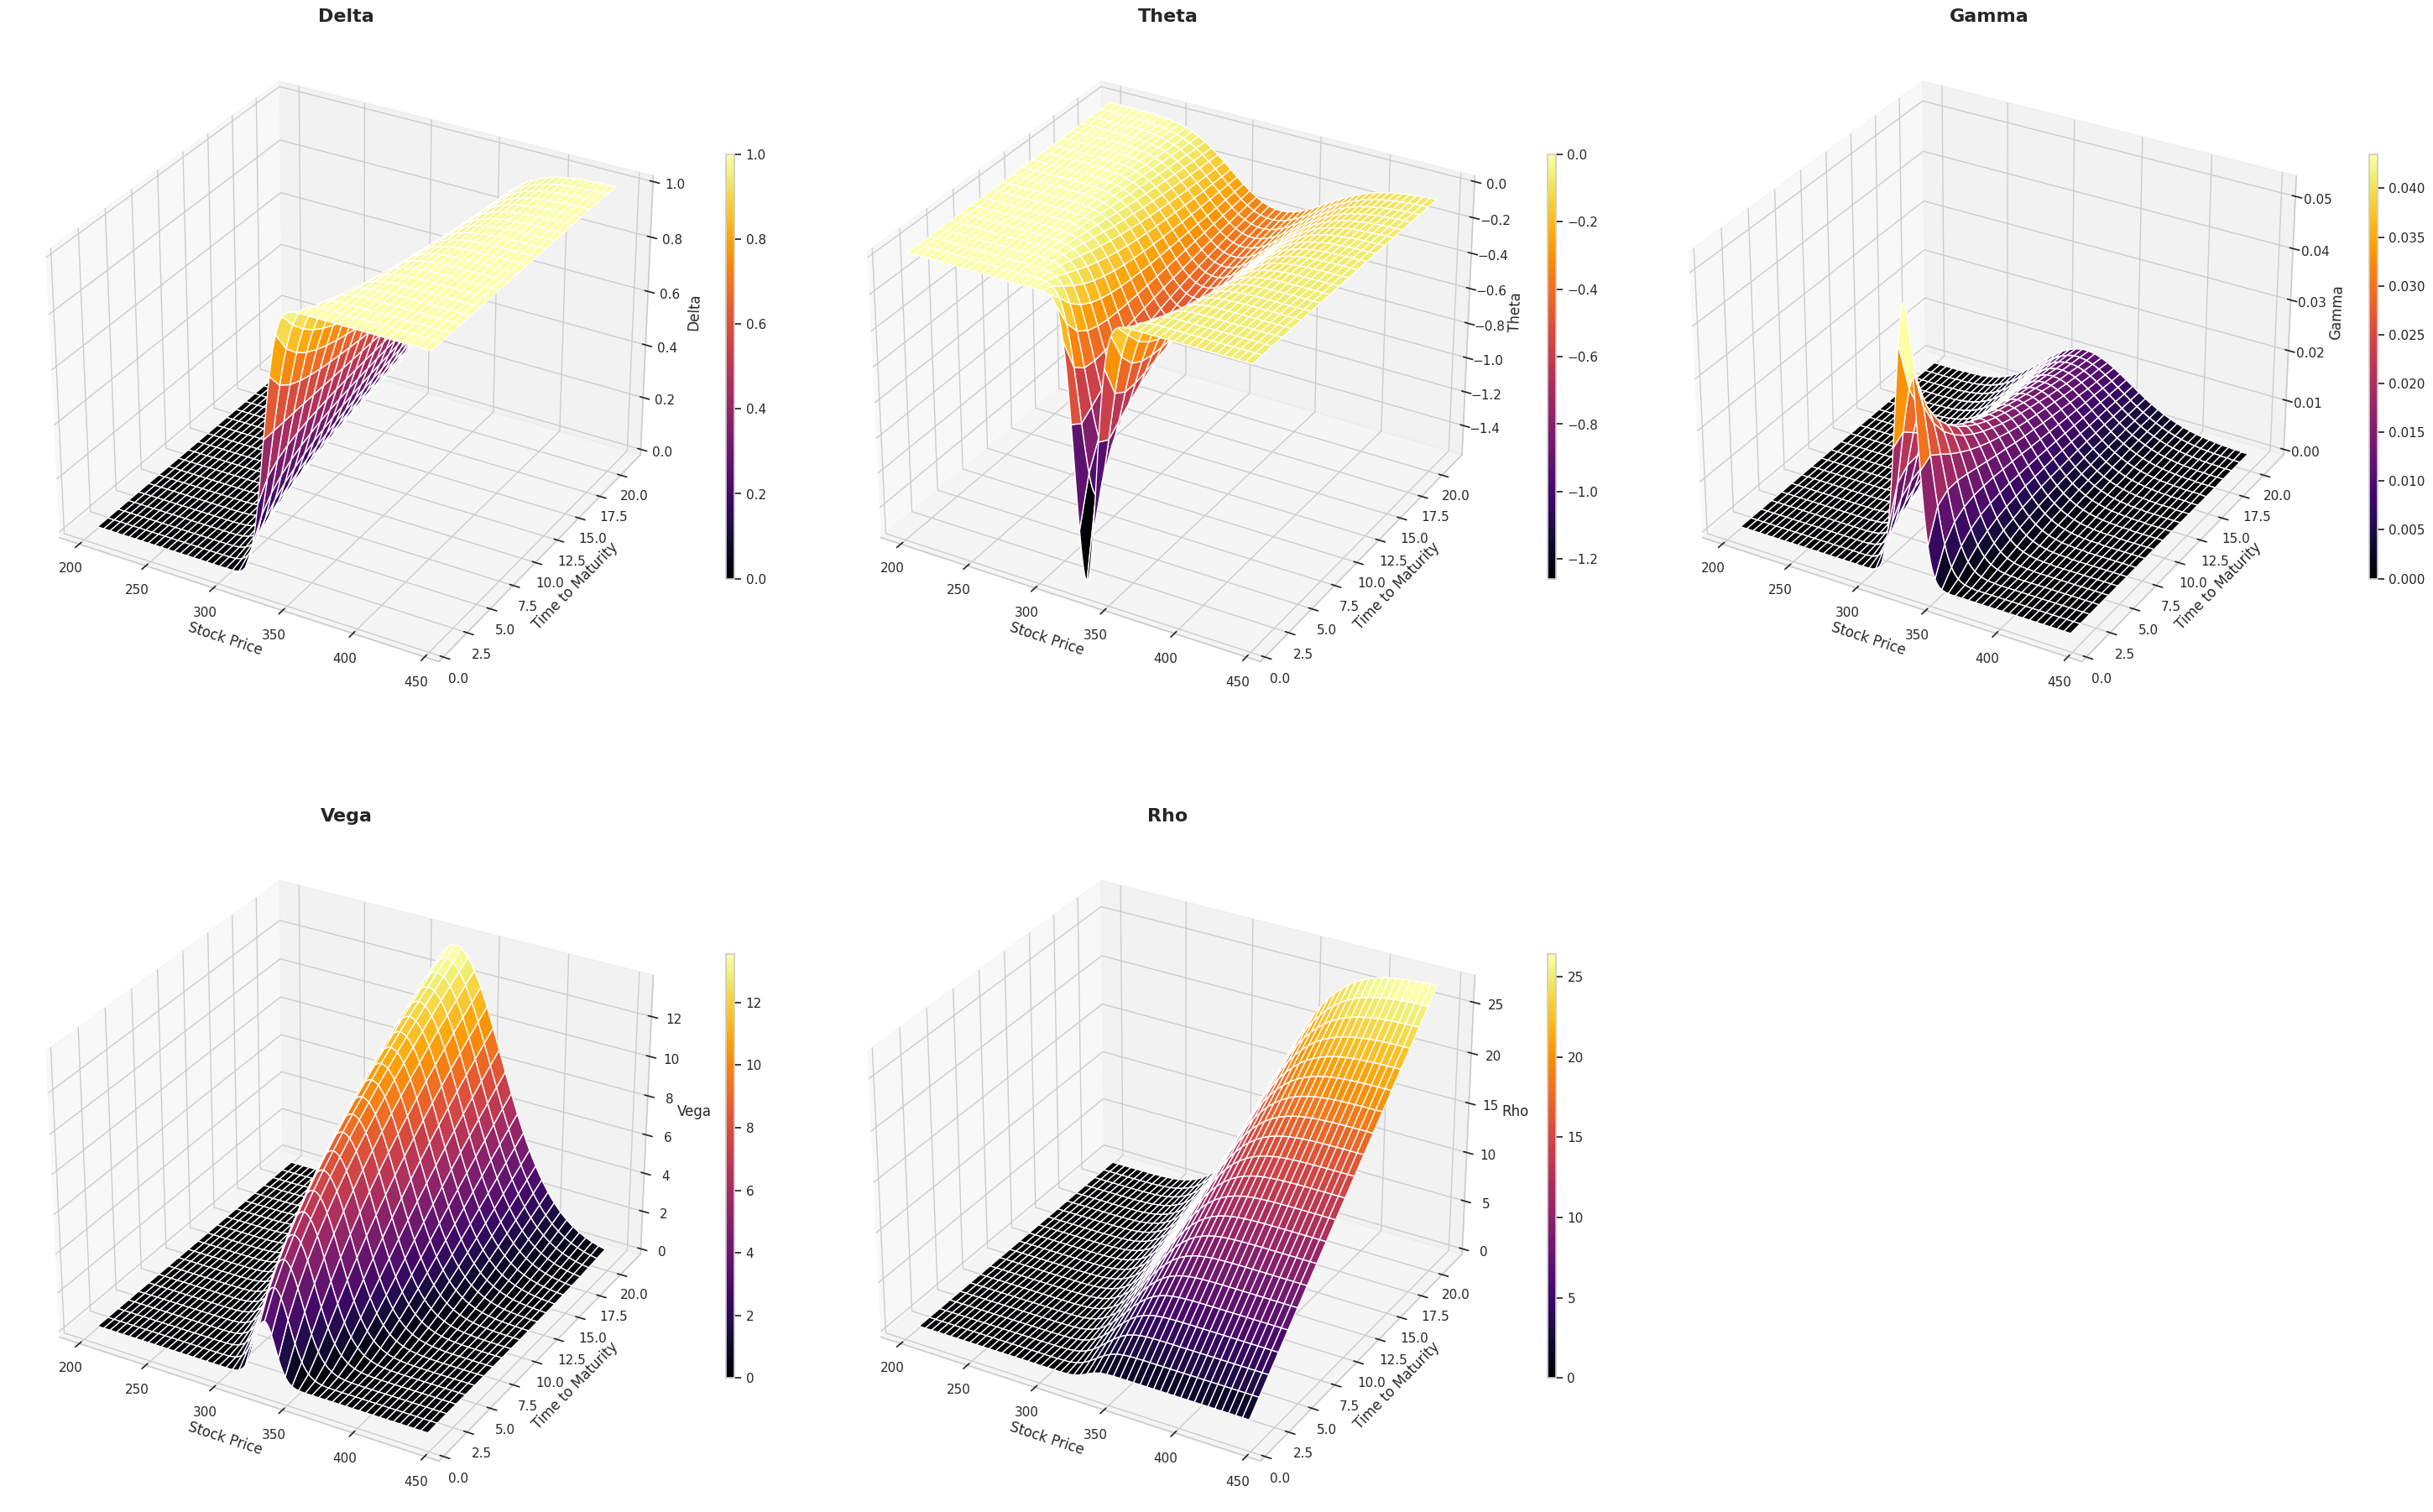

In [53]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate example data (replace this with your actual data)
Z1 = Z[1]
Z2 = Z[2]
Z3 = Z[3]
Z4 = Z[4]
Z5 = Z[5]

# Create a figure with subplots
fig = plt.figure(figsize=(30, 20))

# Subplot 1
ax1 = fig.add_subplot(231, projection='3d')
surf1 = ax1.plot_surface(X, Y, Z1, cmap='inferno')
ax1.set_xlabel('Stock Price')
ax1.set_ylabel('Time to Maturity')
ax1.set_zlabel('Delta')
ax1.set_title('Delta', fontsize=16, fontweight='bold')
cbar1 = fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=50)

# Subplot 2
ax2 = fig.add_subplot(232, projection='3d')
surf2 = ax2.plot_surface(X, Y, Z2, cmap='inferno')
ax2.set_xlabel('Stock Price')
ax2.set_ylabel('Time to Maturity')
ax2.set_zlabel('Theta')
ax2.set_title('Theta', fontsize=16, fontweight='bold')
cbar2 = fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=50)

# Subplot 3
ax3 = fig.add_subplot(233, projection='3d')
surf3 = ax3.plot_surface(X, Y, Z3, cmap='inferno')
ax3.set_xlabel('Stock Price')
ax3.set_ylabel('Time to Maturity')
ax3.set_zlabel('Gamma')
ax3.set_title('Gamma', fontsize=16, fontweight='bold')
cbar3 = fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=50)

# Subplot 4
ax4 = fig.add_subplot(234, projection='3d')
surf4 = ax4.plot_surface(X, Y, Z4, cmap='inferno')
ax4.set_xlabel('Stock Price')
ax4.set_ylabel('Time to Maturity')
ax4.set_zlabel('Vega')
ax4.set_title('Vega', fontsize=16, fontweight='bold')
cbar4 = fig.colorbar(surf4, ax=ax4, shrink=0.5, aspect=50)

# Subplot 5
ax5 = fig.add_subplot(235, projection='3d')
surf5 = ax5.plot_surface(X, Y, Z5, cmap='inferno')
ax5.set_xlabel('Stock Price')
ax5.set_ylabel('Time to Maturity')
ax5.set_zlabel('Rho')
ax5.set_title('Rho', fontsize=16, fontweight='bold')
cbar5 = fig.colorbar(surf5, ax=ax5, shrink=0.5, aspect=50)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

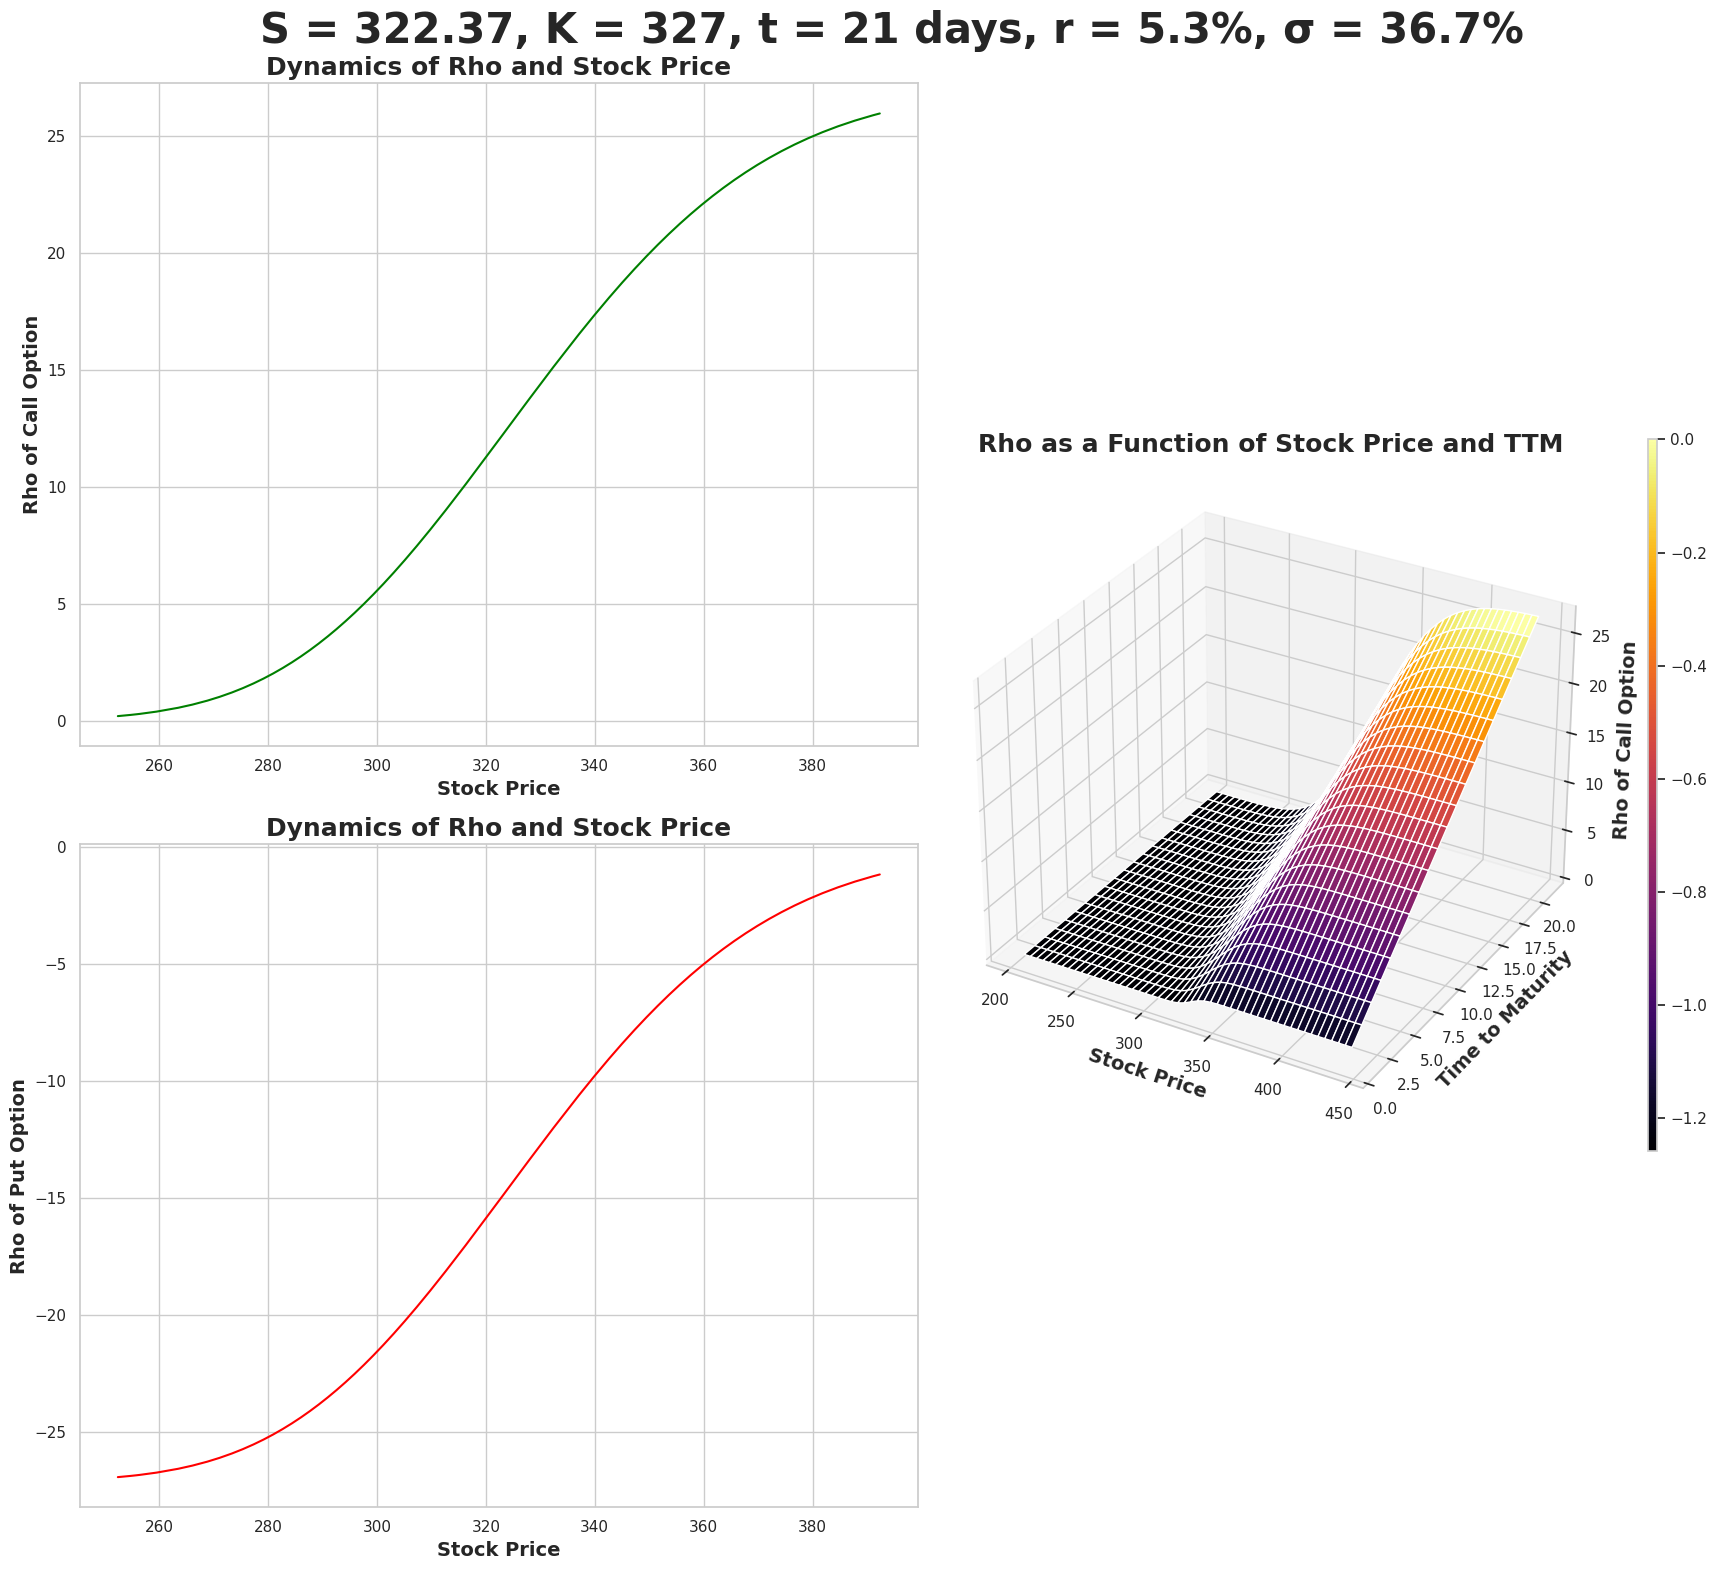

In [54]:
fig = plt.figure(figsize = (18, 16))

fig.suptitle(f'S = {S}, K = {K}, t = {t} days, r = {np.round(r * 100, 2)}%, σ = {np.round(sigma * 100, 2)}%', size = 30, fontweight = 'bold')

ax1 = fig.add_subplot(221)
ax1 = sns.lineplot(data = call_graph, x = 'stock_price', y = 'call_rho', color = 'green')
ax1.set_xlabel('Stock Price', fontsize = 14,fontweight = 'bold')
ax1.set_ylabel('Rho of Call Option', fontsize = 14,fontweight = 'bold')
ax1.set_title('Dynamics of Rho and Stock Price', fontsize = 18,fontweight = 'bold')

ax2 = fig.add_subplot(223)
ax2 = sns.lineplot(data = put_graph, x = 'stock_price', y = 'put_rho', color = 'red')
ax2.set_xlabel('Stock Price', fontsize = 14,fontweight = 'bold')
ax2.set_ylabel('Rho of Put Option', fontsize = 14,fontweight = 'bold')
ax2.set_title('Dynamics of Rho and Stock Price', fontsize = 18,fontweight = 'bold')

ax3 = fig.add_subplot(122, projection='3d')
surf = ax3.plot_surface(X, Y, Z[5], cmap='inferno')
ax3.set_xlabel('Stock Price', fontsize = 14,fontweight = 'bold')
ax3.set_ylabel('Time to Maturity', fontsize = 14,fontweight = 'bold')
ax3.set_zlabel('Rho of Call Option', fontsize = 14,fontweight = 'bold')
ax3.set_title('Rho as a Function of Stock Price and TTM', fontsize = 18, fontweight = 'bold')
cbar = fig.colorbar(surf2, ax=ax3, shrink=0.5, aspect=80)

plt.tight_layout()
plt.show()